In [39]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os 
from random import randint

PATH = "Documents/Image Classification/catsvsdogs/train"
pictures = os.listdir(PATH)

CPU times: user 6 µs, sys: 1e+03 ns, total: 7 µs
Wall time: 13.1 µs


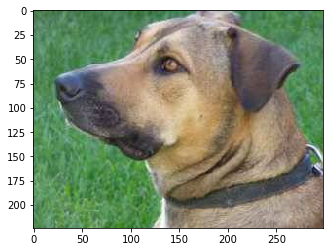

In [2]:
def get_random_image():
    RAND_INT = randint(0, len(pictures))
    return RAND_INT

def show_random_image():
    img = cv2.imread(PATH + "/" + pictures[RAND_INT], 1)
    return plt.imshow(cv2.cvtColor(img, cv2.CV_32S))



RAND_INT = get_random_image()
show_random_image()
#%time

CPU times: user 6 µs, sys: 1 µs, total: 7 µs
Wall time: 15.3 µs


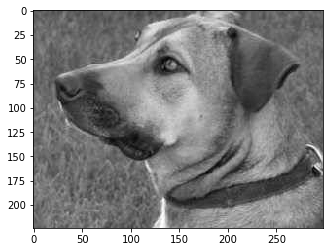

In [3]:
def to_gray(p):
    img = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
    return img

gray_image = to_gray(PATH + "/" + pictures[RAND_INT])

plt.imshow(gray_image, cmap='gray')
#%time

In [4]:
def get_sift_features(gray_image):
    sift = cv2.xfeatures2d.SIFT_create()
    
    kp, desc = sift.detectAndCompute(gray_image, None)
    return kp, desc

kp, desc = get_sift_features(gray_image)


print("There are " + str(len(kp)) + " keypoints.")
print("Each keypoint has a desciptor of size " + str(desc.shape[1]) + ".")
#%time

There are 501 keypoints.
Each keypoint has a desciptor of size 128.
CPU times: user 15 µs, sys: 5 µs, total: 20 µs
Wall time: 37.9 µs


In [5]:
#iterate through path and store features in dataframe
descriptors = np.empty(0)
i = 0
for file in os.listdir(PATH):
    
    if str(file)[:3] == "dog": 
        i += 1
        #Read as grayscale
        img = cv2.imread(PATH + "/" + file, cv2.IMREAD_GRAYSCALE)
        #SIFT
        kp, desc = get_sift_features(img)
        #Store descriptors in array
        if descriptors.size > 0:
            descriptors = np.append(descriptors, desc, axis=0)
            #print(descriptors.shape)
        else: descriptors = desc
        if i >= 500:
            break

print("There are " + str(descriptors.shape[0]) + " keypoints.")

There are 436972 keypoints.


In [6]:
np.savetxt("Documents/Image Classification/catsvsdogs/desc_dogs.csv", descriptors, delimiter=",")

In [12]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=25, random_state=0).fit(descriptors)

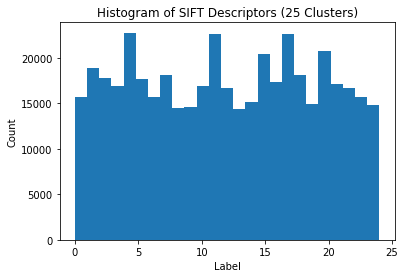

In [45]:
plt.hist(kmeans.labels_, bins=25)
plt.title("Histogram of SIFT Descriptors (25 Clusters)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()


# Review
 - **SIFT descriptors were extracted from 500 dog images**
     - Each image has variable number of descriptors
     - Descriptors are flat 128 pixel arrays
     - Roughly 500,000 descriptors were extracted
 - **K-Means clustering was performed to find cluster groupings**
     - 25 clusters were initially chosen
         - **More research is needed on how to choose K**
     - Histogram does not have many significant labels that standout over others
         - Dimensionality reduction like PCA might be beneficial as k-means suffers in high-dimensionality problems
        

In [47]:
from sklearn.decomposition import PCA

pca = PCA()

pca.fit(descriptors)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [54]:
pca.explained_variance_ratio_

array([ 0.11356773,  0.09419917,  0.05473585,  0.04671022,  0.04289294,
        0.04259749,  0.03570898,  0.03525243,  0.03084814,  0.02686033,
        0.02210236,  0.01930207,  0.01814865,  0.01793933,  0.0151179 ,
        0.01504348,  0.01486237,  0.01476486,  0.0145805 ,  0.01335516,
        0.01211214,  0.01026269,  0.01021307,  0.00987273,  0.00897821,
        0.00880798,  0.0087263 ,  0.00785795,  0.00721371,  0.00692725,
        0.00665305,  0.00657969,  0.00656845,  0.00593361,  0.00582027,
        0.00565864,  0.00559402,  0.00532117,  0.005284  ,  0.00518197,
        0.00515853,  0.00457648,  0.00453137,  0.00448636,  0.00444583,
        0.00433325,  0.004295  ,  0.00419432,  0.00415835,  0.00395801,
        0.00393777,  0.00380515,  0.00374434,  0.00360446,  0.00333401,
        0.00329888,  0.00294425,  0.00287804,  0.00284302,  0.00267349,
        0.00258055,  0.00252056,  0.00247563,  0.00241221,  0.00240736,
        0.00227266,  0.00224602,  0.00222141,  0.00215219,  0.00

Only first 5 components explain variance

# Transform X to 5-component space & redo K-Means clusters

In [79]:
descriptors_pca = pca.transform(descriptors)

In [94]:
#descriptors_pca[:descriptors_pca.shape[0], 5]
five_components = descriptors_pca[:, [0,1,2,3,4]]



(436972, 5)

In [95]:
five_components

array([[ -31.03868675,  310.00338745,   31.75766563,  -30.92336464,
          17.88244438],
       [ -85.27986145,  250.837677  ,  -32.86390686,   17.31791687,
          82.58699036],
       [ 107.79403687,  286.36053467,   29.2795105 ,   30.3239975 ,
          30.02606201],
       ..., 
       [ -20.46386719,  301.42315674,   51.54295349,   40.00088501,
         -31.59651756],
       [  14.50427723,  264.73034668,  -32.20103073,   54.35520172,
         -12.1990509 ],
       [ 135.28125   ,  255.62953186,   55.82656479,   76.14680481,
         -38.70099258]], dtype=float32)

In [96]:
kmeans_5 = KMeans(n_clusters=25, random_state=0).fit(five_components)

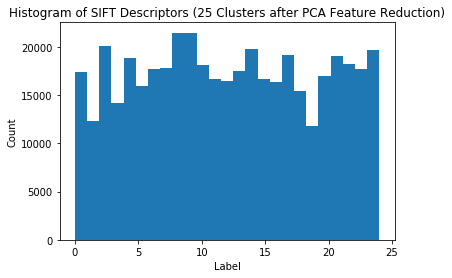

In [99]:
plt.hist(kmeans_5.labels_, bins=25)
plt.title("Histogram of SIFT Descriptors (25 Clusters after PCA Feature Reduction)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

Using 5 Components... no big difference
Need to figure try new cluster counts